# Fashion mnist notebook

* The fashion mnist data consists of 70,000 images divided into 60,000 training and 10,000 testing samples. Dataset sample consists of 28x28 grayscale image, associated with a label from 10 classes that represents the article of clothing . This is a multiclass classification problem.


* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.


* In this notebook we will try to predict which label the images belongs to. (The labels will comes next), by using dimensionality reduction (there are 784 dimensions) and more.

### Import necessary libraries

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn import metrics
import xgboost
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import StackingClassifier
from sklearn.cluster import KMeans

### Import the data

In [7]:
df_train=pd.read_csv("C:/Users/97254/.conda/fashion-mnist_train.csv")
df_test=pd.read_csv("C:/Users/97254/.conda/fashion-mnist_test.csv")

In [8]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_train.shape

(60000, 785)

#### There are 785 columns, each columm is one pixel, so there are 784 pixels as we said (the 'label' column is our target )

### Labels

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

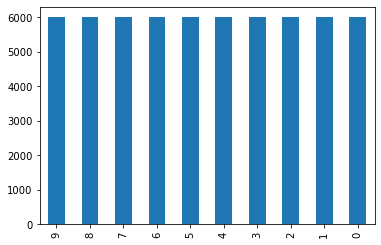

In [10]:
df_train.label.value_counts().plot(kind='bar')

* So there are 10 labels, and 60000 samples. each one of the labels has 6000 samples. 

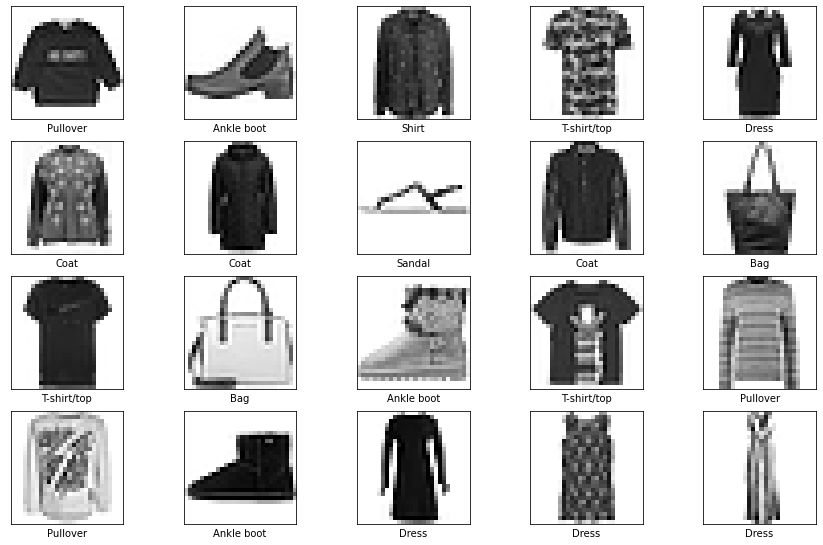

In [11]:
label = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
target = df_train[['label']].iloc[:, :]
plt.figure(figsize=(15,12))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(df_train.drop(['label'],axis=1).iloc[i, :]).reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(label[target.label.iloc[i]])

# PCA

### Choosing the right number of Dimensions

####  First, i will split the data into train-test (without dimensionality reduction)

In [105]:
y = df_train['label'] 
y_test=df_test['label']
x = df_train.drop(['label'], axis=1).to_numpy() 
x_test = df_test.drop(["label"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=42)

#### Now, let's computes the number of dimensions (approximatly) required to reach high percentages of the training set’s variance (I want to take minimun number of dimensions so the model will be compressed)


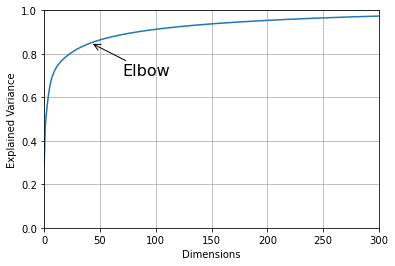

In [13]:
pca = PCA()
pca.fit(X_train)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.axis([0, 300, 0, 1])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.annotate("Elbow", xy=(42, 0.85), xytext=(70, 0.7),arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)


* 'elbow' shows where the explained variance stops growing fast

**We can see that even a before 50 dimensions the explained variance stops growing fast! and if i take even 100 dimensions i wouldn't lose too much explained variance**

**It means i can take even only about 50 dimensions instead of 784 dimensions, most of the variance is preserved, and my data will be less than 10% from the original size!**

### Now let's check how many important features has with random forrest classifier

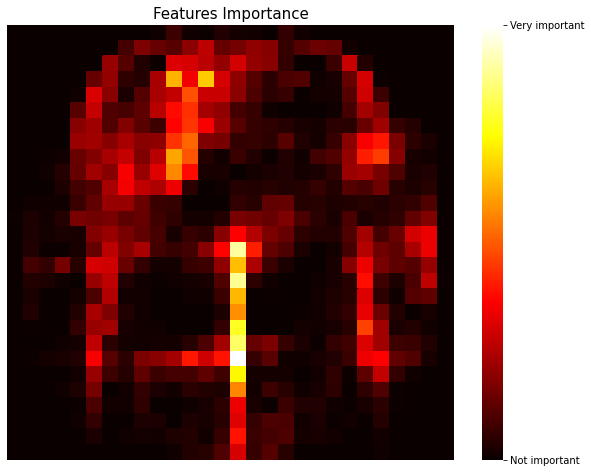

In [14]:
model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
model.fit(X_train, y_train)

importances = model.feature_importances_
pixels = np.reshape(importances,(28,28))

plt.figure(figsize= (10,8))
plot = sns.heatmap(pixels,cmap=plt.cm.hot)
plt.xticks([], [])
plot.set_yticks([])
plot.set_yticks([], minor=True)
colorbar = plot.collections[0].colorbar
colorbar.set_ticks([0,max(importances)])
colorbar.set_ticklabels(['Not important','Very important'])
plt.title('Features Importance',size = 15)
plt.show()

**Also here, we can see that most of the features are not important, we actually don't need them to the prediction**

### So i decided to take only 25 features instead of 784

**Fashion mnist with 25 dimensions**

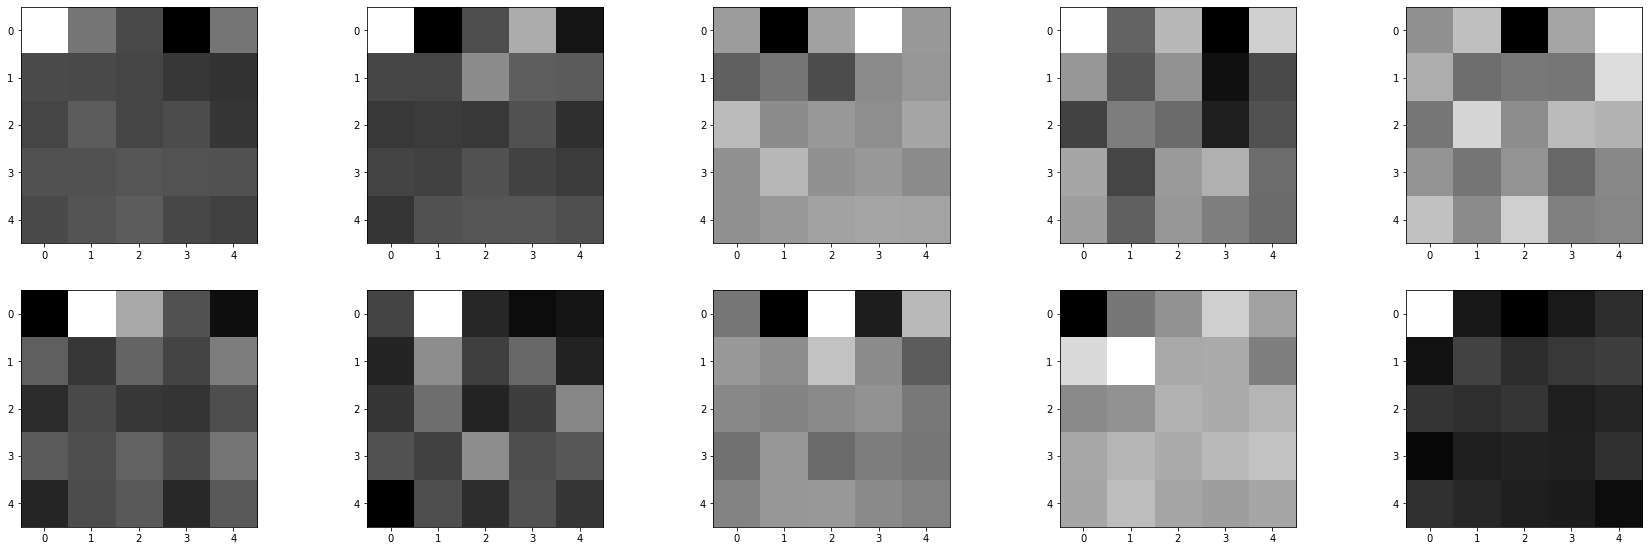

In [60]:
pca = PCA(n_components=25)
X_reduced = pca.fit_transform(X_train)

plt.figure(figsize=(30,20))
for i in range(10):
    plt.subplot(4,5,i+1)
    plt.imshow(X_reduced[i].reshape(5,5), cmap="gist_yarg")
    plt.grid(False)



## Modeing

In [116]:
def pipe(model):
    pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components=25)),('model', model)])
    return pipe

In [117]:
def result(model):
    res= pipe(model)
    res.fit(X_train, y_train)
    y_predict = res.predict(X_test)
    print(round(metrics.accuracy_score(y_test,y_predict)*100,4),"%")

### KNN

In [118]:
knn = KNeighborsClassifier(n_neighbors = 5)
result(knn)

84.0083 %


### Random forrest

In [31]:
rfc=RandomForestClassifier()
result(rfc)

85.2833 %


* Best k is 7

### AdaBoost

In [21]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,algorithm="SAMME.R", learning_rate=0.5)
result(ada)

52.625 %


### XGboost

In [103]:
xgbc=xgb.XGBClassifier(n_estimators=50,use_label_encoder=False,eval_metric='mlogloss')
result(xgbc)

85.1583 %


In [119]:
voting = VotingClassifier(estimators=[('knn', knn), ('rfc', rfc), ('xgb', xgbc)],voting='hard')
result(voting)

85.6667 %


In [120]:
stacking=StackingClassifier(estimators=[('rf',rfc),('xgbc',xgbc)],final_estimator=LogisticRegression())
result(stacking)

85.3167 %


### What is the difference if i take 100 dimensions?

In [25]:
def pipe100(model):
    pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components=100)),('model', model)])
    return pipe

In [92]:
def result100(model):
    res= pipe100(model)
    res.fit(X_train, y_train)
    y_predict = res.predict(X_test)
    print(round(metrics.accuracy_score(y_test,y_predict)*100,4),"%")

In [93]:
voting = VotingClassifier(estimators=[('knn', knn), ('rfc', rfc), ('xgb', xgb)],voting='hard')
result100(voting)

[18:04:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
87.6917 %


In [104]:
xgbc=xgb.XGBClassifier(n_estimators=50,use_label_encoder=False,eval_metric='mlogloss')
result100(xgbc)

87.0667 %


* The difference is so small, so i prefered to took 25 dimensions and not more than that

### grid search
* I'm going to use grid search to try to improve the scores
* I will find the best parameters for each model i used
* Then, i will train it on the reduced train set with 25 features, as i did before
* finally, evaluate on the reduced test set

In [124]:
# 25 dimensions
pca = PCA(n_components=25)
X_train_reduced = pca.fit_transform(X_train)
#transform also the test set
X_test_red=pca.transform(X_test)

### KNN

In [125]:
## Fit on the reduced train set
param_grid_knn=[{'n_neighbors': [5,7,10,15,17],'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]
model=KNeighborsClassifier()
grid_search_knn=GridSearchCV(model,param_grid_knn,cv=2,scoring='accuracy')
grid_search_knn.fit(X_train_reduced, y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'n_neighbors': [5, 7, 10, 15, 17]}],
             scoring='accuracy')

In [126]:
## Best params
grid_knn=grid_search_knn.best_params_
grid_knn

{'algorithm': 'auto', 'n_neighbors': 10}

In [127]:
## Evaluate with the best parameters on the reduced test set
knn_res=grid_search_knn.best_estimator_
print(round(knn_res.score(X_test_red,y_test)*100,4),"%")

84.9083 %


#### Improvement by 1%

### Random forrest

In [128]:
## Fit on the reduced train set
param_grid_rf=[{'n_estimators':[75,100,150,175,200],'max_depth':[5,7,12,15,18]}]
model=RandomForestClassifier()
grid=GridSearchCV(model,param_grid_rf,cv=2,scoring='accuracy')
grid.fit(X_train_reduced, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5, 7, 12, 15, 18],
                          'n_estimators': [75, 100, 150, 175, 200]}],
             scoring='accuracy')

Text(0.5, 1.0, 'score for estimators')

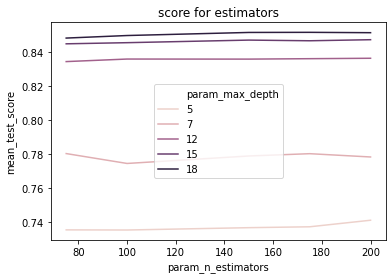

In [129]:
cv_res=pd.DataFrame(grid.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend='full',hue='param_max_depth')
plt.title('score for estimators')

In [130]:
## Best params
grid.best_params_

{'max_depth': 18, 'n_estimators': 175}

In [131]:
## Evaluate with the best parameters on the reduced test set
rf_res=grid.best_estimator_
print(round(rf_res.score(X_test_red,y_test)*100,4),"%")

85.3667 %


#### The improvement is very neglectible

### AdaBoost

In [133]:
## Fit on the reduced train set
param_grid_ada=[{'n_estimators':[50,75,100,125,150],'learning_rate':[0.2,0.5,1,1.5,2]}]
model=AdaBoostClassifier(n_estimators=50,random_state=10)
grid_search_ada=GridSearchCV(model,param_grid_ada,cv=2,scoring='accuracy')
grid_search_ada.fit(X_train_reduced, y_train)

GridSearchCV(cv=2, estimator=AdaBoostClassifier(random_state=10),
             param_grid=[{'learning_rate': [0.2, 0.5, 1, 1.5, 2],
                          'n_estimators': [50, 75, 100, 125, 150]}],
             scoring='accuracy')

Text(0.5, 1.0, 'score for estimators')

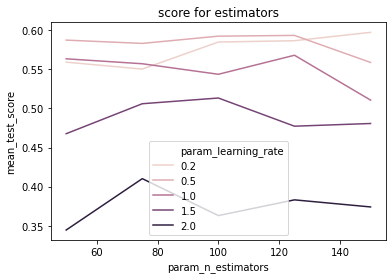

In [134]:
cv_res=pd.DataFrame(grid_search_ada.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend='full',hue='param_learning_rate')
plt.title('score for estimators')

In [135]:
## Best params
grid_search_ada.best_params_

{'learning_rate': 0.2, 'n_estimators': 150}

In [136]:
## Evaluate with the best parameters on the reduced test set
ada_res=grid_search_ada.best_estimator_
print(round(ada_res.score(X_test_red,y_test)*100,4),"%")

58.125 %


#### The improvement is by 6%, but adaboost here is very low compare to other models

### XGboost

In [141]:
## Fit on the reduced train set
param_grid_xg=[{'n_estimators':[120,140,160,180,200],'learning_rate':[0.2,0.5,1,1.5]}]
model=xgb.XGBClassifier(eval_metric='mlogloss')
grid_search_xg=GridSearchCV(model,param_grid_xg,cv=2,scoring='accuracy')
grid_search_xg.fit(X_train_reduced, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

Text(0.5, 1.0, 'score for estimators')

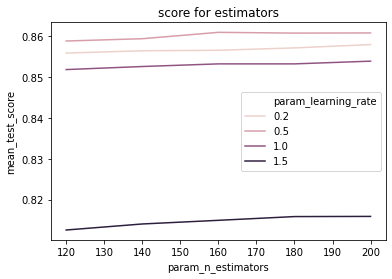

In [142]:
cv_res=pd.DataFrame(grid_search_xg.cv_results_)
sns.lineplot(data=cv_res,y='mean_test_score',x='param_n_estimators',legend='full',hue='param_learning_rate')
plt.title('score for estimators')

In [143]:
grid_search_xg.best_params_

{'learning_rate': 0.5, 'n_estimators': 160}

In [144]:
xg_res=grid_search_xg.best_estimator_
print(round(xg_res.score(X_test_red,y_test)*100,4),"%")

86.3333 %


**Improvement by more than 1%**

In [148]:
voting_ = VotingClassifier(([('xgb',xg_res),('rfc',rf_res),('knn',knn_res)]),voting='hard')
voting_.fit(X_train_reduced,y_train)
print(round(voting_.score(X_test_red,y_test)*100,4),"%")

86.2667 %


### Stacking

In [146]:
col_sc20=StackingClassifier([('xgb',xg_res),('rfc',rf_res),('knn',knn_res)])
col_sc20.fit(X_train_reduced,y_train)
print(round(col_sc20.score(X_test_red,y_test)*100,4),"%")

86.675 %


**Also here,improvement by more than 1%, while i used now the best parameters for the classifiers**

## Summary

In [149]:
data = {'knn':  ['84.9%'],
        'Random Forest': ['85.36%'],
        'voting': ['86.26%'],
        'AdaBoost':['58.12%'],
        'xgboost':['86.33%'],
        'stacking':['86.67%'],
        }
df = pd.DataFrame (data, columns = ['knn','Random Forest','AdaBoost','xgboost','voting','stacking']
                   ,index=['accuracy'])
df

,knn,Random Forest,AdaBoost,xgboost,voting,stacking
accuracy,84.9%,85.36%,58.12%,86.33%,86.26%,86.67%
